## **Sentiment Analysis**

### 2. Đọc bộ dữ liệu:

In [2]:
# Load dataset
import pandas as pd

df = pd.read_csv('./IMDB-Dataset.csv')

# Remove duplicate rows
df = df.drop_duplicates()

In [11]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions

stop = set([word for word in stopwords.words('english') if word not in ['no', 'not']])

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):

    wl = WordNetLemmatizer()

    soup = BeautifulSoup(text, "html.parser") # Removing html tags
    text = soup.get_text()
    text = expand_contractions(text) # Expanding chatwords and contracts clearing contractions
    emoji_clean = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([
        word.lower() for word in text if word not in string.punctuation
    ]) #remove punctuation and make text lowercase
    text = " ".join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    return text

df['review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nghgkim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nghgkim/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 3. Phân tích dữ liệu:

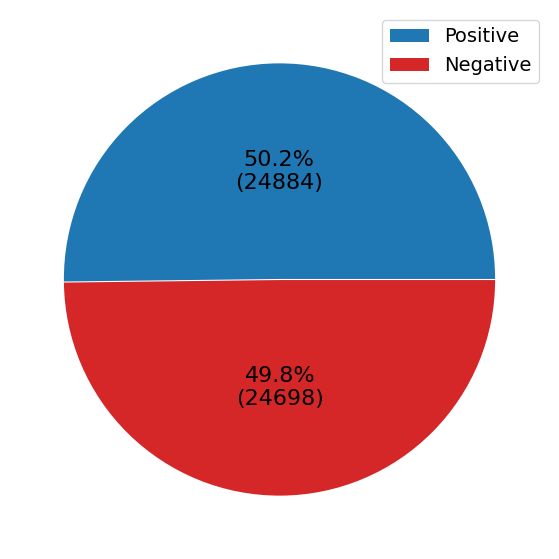

In [4]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Creating autocpt arguments
def func (pct, allvalues):
    absolute = int(pct / 100.* np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

freq_pos = len(df[df['sentiment'] == 'positive'])
freq_neg = len(df[df['sentiment'] == 'negative'])

data = [freq_pos, freq_neg]

labels = ['positive', 'negative']

# Create pie chart
pie, ax = plt.subplots(figsize=[11, 7])
plt.pie(x=data, autopct=lambda pct: func(pct, data), explode=[0.0025]*2, pctdistance=0.5, colors=[sns.color_palette()[0], 'tab:red'], textprops={'fontsize':16})
# plt . title ( ' Frequencies of sentiment labels ', fontsize =14, fontweight = ' bold ')
labels = [r'Positive', r'Negative']
plt.legend(labels, loc="best", prop={'size': 14})
pie.savefig("PieChart.png")
plt.show()

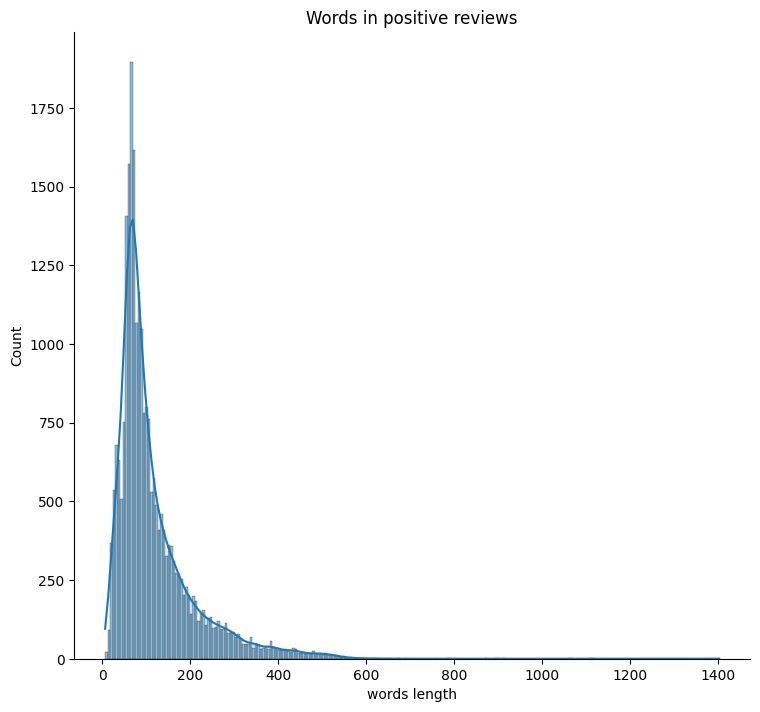

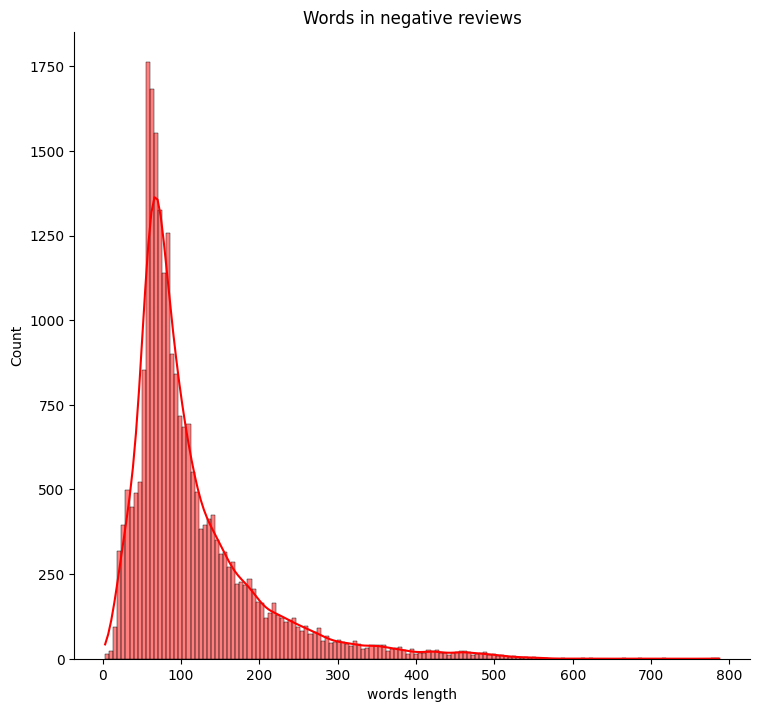

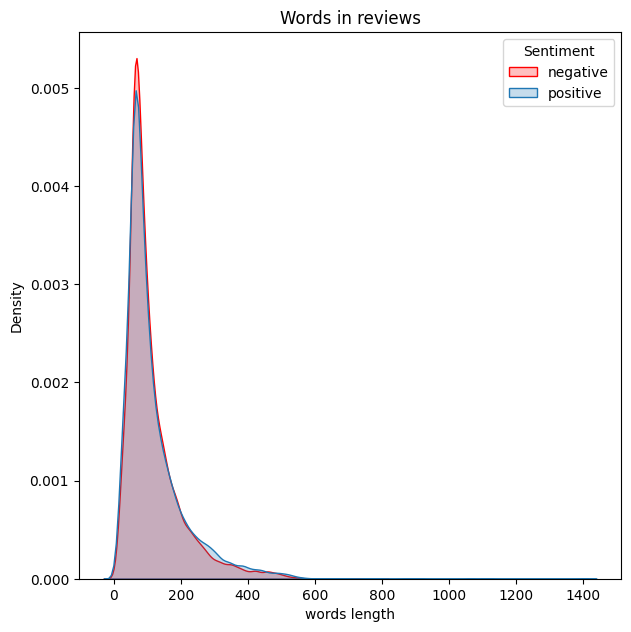

In [12]:
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True,  height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')
plt.show(hist_positive)

hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True,  height=7, aspect=1.1, legend=False,  palette=['red']
).set(title='Words in negative reviews')
plt.show(hist_negative)

plt.figure(figsize=(7,7.1))
kernel_distibution_number_words_plot  = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True,  palette=[sns.color_palette()[0],'red']
).set(title='Words in reviews')
plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distibution_number_words_plot)

### 4. Chia tập train và test:

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()
x_data = df['review']
y_data = label_encode.fit_transform(df['sentiment'])

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

### 5. Biểu diễn văn bản thành vector:

In [14]:
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

### 6. Huấn luyện và đánh giá mô hình:

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


### **Decision Tree**

In [18]:
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
dt_classifier.fit(x_train_encoded, y_train)
y_pred = dt_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.7118080064535646

### **Random Forest**

In [19]:
rf_classifier = RandomForestClassifier(
    random_state=42
)
rf_classifier.fit(x_train_encoded, y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8396692548149642